In [43]:
import os
from sys import stdout

import nglview as ngl
import pytraj as pt
import numpy as np
import matplotlib.pyplot as plt

font = {'family': 'serif',
        'weight': 'normal',
        'size': 22,
        }
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# WTM-eABF for a particle in a double-well potential

As a simple test case we consider a single particle on a 2D double well potential. An optimal Collective Variable (CV) for the transition is trivially given by the x-Axis.

In [50]:
def double_well_potential(coord_x, coord_y):
    """ Analytical double well potential
    """
    a = 8.0e-6
    b = 0.5
    d = 80.0
    e = 160.0

    s1 = (coord_x-d)*(coord_x-d)
    s2 = (coord_x-e)*(coord_x-e)

    return a * s1*s2 + b*coord_y*coord_y

coords_x = np.arange(60,181,1.0)
coords_y = np.arange(-8,8,0.1)
xx,yy = np.meshgrid(coords_x,coords_y)

PES = double_well_potential(xx,yy)

In [58]:
def plot_potential(axs, xx, yy, PES):

    # calculate the potential energy surface
    coords_x = np.arange(60,181,1.0)
    coords_y = np.arange(-8,8,0.1)
    xx,yy = np.meshgrid(coords_x,coords_y)

    PES = double_well_potential(xx,yy)
    
    # plot the potential energy surface
    CS = axs.contour(xx, yy, PES, colors='black', levels=12, linewidths=2.5, zorder=1)
    plt.clabel(CS, CS.levels, inline='true', fontsize=25, fmt="%5.3f")
    axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
    axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
    axs.set_ylabel('y / \AA', fontsize=40)
    axs.set_xlabel('x / \AA', fontsize=40)
    axs.set_xlim([70,170])
    axs.set_ylim([-5,5])

    axs.spines['bottom'].set_linewidth(3)
    axs.spines['top'].set_linewidth(3)
    axs.spines['left'].set_linewidth(3)
    axs.spines['right'].set_linewidth(3)
    return axs

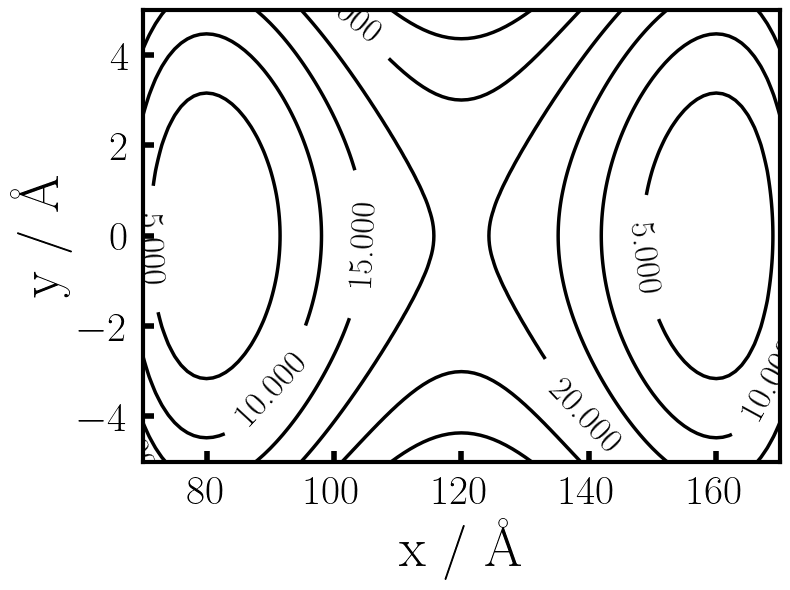

In [60]:
plt.rcParams["figure.figsize"] = [8,6]
fig, axs = plt.subplots(ncols=1)

axs = plot_potential(axs, xx, yy, PES)

axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()
plt.show()
plt.close()

### Setup the simulation

We will make use of the WTM-eABF sampling algorithm along the x-axis. 

In [94]:
from adaptive_sampling.sampling_tools import *
from adaptive_sampling.interface.interfaceMD_2D import MD
from adaptive_sampling.units import *

# ------------------------------------------------------------------------------------
# define collective variables
cv_atoms        = []              # not needed for 2D potentials
minimum         = 70.0            # minimum of the CV
maximum         = 170.0           # maximum of the CV
bin_width       = 2.0             # bin with along the CV

collective_var = [["x", cv_atoms, minimum, maximum, bin_width]]

# ------------------------------------------------------------------------------------
# setup MD
mass      = 10.0   # mass of particle in a.u.
seed      = 42     # random seed
dt        = 5.0e0  # stepsize in fs
temp      = 300.0  # temperature in K

coords_in = [71.0, 0.5]

the_md = MD(
    mass_in=mass,
    coords_in=coords_in,
    potential="1",
    dt_in=dt,
    target_temp_in=temp,
    seed_in=seed,
)
the_md.calc_init()
the_md.calc_etvp()

# --------------------------------------------------------------------------------------
# Setup the sampling algorithm
eabf_ext_sigma    = 2.0     # thermal width of coupling between CV and extended variable 
eabf_ext_mass     = 20.0    # mass of extended variable in a.u.
abf_nfull         = 500     # number of samples per bin when abf force is fully applied
mtd_hill_height   = 1.0     # MtD hill height in kJ/mol   
mtd_hill_std      = 4.0     # MtD hill width
mtd_well_tempered = 1000.0  # MtD Well-tempered temperature
mtd_frequency     = 100     # MtD frequency of hill creation
output_freq       = 1000    # frequency of writing outputs

the_bias = WTMeABF(
    eabf_ext_sigma, 
    eabf_ext_mass, 
    mtd_hill_height,
    mtd_hill_std,
    the_md, 
    collective_var,         # collective variable
    output_freq=output_freq,       
    f_conf=0.0,             # confinement force of CV at boundaries
    nfull=abf_nfull,        
    equil_temp=temp,        # equilibrium temperature of simulation
    well_tempered_temp=mtd_well_tempered,
    hill_drop_freq=mtd_frequency,
    force_from_grid=True,   # accumulate metadynamics force and bias on grid
    kinetics=True,          # calculate importent metrics to get accurate kinetics
    verbose=False,          # print verbose output
)
the_bias.step_bias()

THE RANDOM NUMBER SEED WAS: 42


array([7.97339956e-06, 0.00000000e+00])

In [95]:
def print_output(the_md):
    print("%11.2f\t%14.6f\t%14.6f\t%14.6f\t%14.6f\t%14.6f\t%14.6f" % (
        the_md.step * the_md.dt * atomic_to_fs,
        the_md.coords[0],
        the_md.coords[1],
        the_md.epot,
        the_md.ekin,
        the_md.epot + the_md.ekin,
        the_md.temp,
    ))

### Run MD

In [96]:
# remove old output
if True:
    os.system("rm CV_traj.dat")

In [103]:
def run_md
nsteps     = 100000
traj_freq  = 10
print_freq = 1000
x,y        = [],[]
biased     = True

print(
    "%11s\t%14s\t%14s\t%14s\t%14s\t%14s\t%14s"
    % ("time [fs]", "x", "y", "E_pot", "E_kin", "E_tot", "Temp")
)
print_output(the_md)

while the_md.step < nsteps:
    the_md.step += 1

    the_md.propagate(langevin=True)
    the_md.calc()

    if biased:
        the_md.forces += the_bias.step_bias()

    the_md.up_momenta(langevin=True)
    the_md.calc_etvp()

    if the_md.step % print_freq == 0:
        print_output(the_md)
    
    if the_md.step % traj_freq == 0:
        x.append(the_md.coords[0])
        y.append(the_md.coords[1])

  time [fs]	             x	             y	         E_pot	         E_kin	         E_tot	          Temp
  500000.00	     85.402814	      2.274751	      0.001480	      0.001007	      0.002487	    635.657977


### Trajectory along the x-coordinate:

In [98]:
cv_traj = np.loadtxt('CV_traj.dat', skiprows=1)

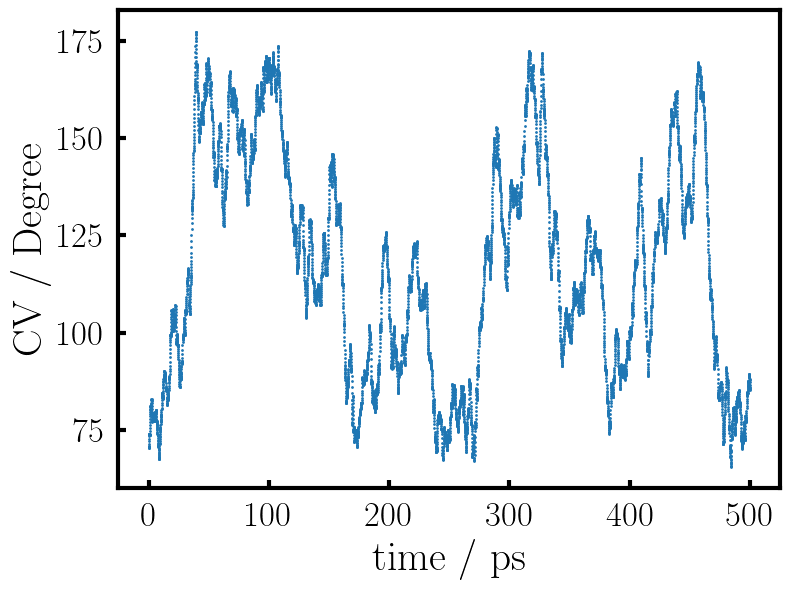

In [99]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))
axs.scatter(cv_traj[::10,0]/1000, cv_traj[::10,1], s=1)
#axs.set_yticks([-180,0,180])
axs.set_xlabel('time / ps', fontsize=30)
axs.set_ylabel('CV / Degree', fontsize=30)
axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

### Compute the PMF

Now we will use the MBAR estimator to calculate the unbiased weights of simulation frames. From those we compute the PMF along $x$.

In [100]:
from adaptive_sampling.processing_tools import mbar
ext_sigma = 2.0    # thermal width of coupling between CV and extended variable 

# grid for free energy profile can be different than during sampling
minimum   = 70.0    
maximum   = 170.0    
bin_width = 1.0  
grid = np.arange(minimum, maximum, bin_width)

cv = cv_traj[:,1]  # trajectory of collective variable
la = cv_traj[:,2]  # trajectory of extended system

# run MBAR and compute free energy profile and probability density from statistical weights
traj_list, indices, meta_f = mbar.get_windows(grid, cv, la, ext_sigma, equil_temp=300.0)

exp_U, frames_per_traj = mbar.build_boltzmann(
    traj_list, 
    meta_f, 
    equil_temp=300.0,
)

weights = mbar.run_mbar(
    exp_U,
    frames_per_traj,
    max_iter=10000,
    conv=1.0e-4,
    conv_errvec=1.0,
    outfreq=100,
    device='cpu',
)

pmf_mbar, rho_mbar = mbar.pmf_from_weights(grid, cv[indices], weights, equil_temp=300.0)

Start of the self-consistent iteration.
Iter    1:	Conv=  1.1328170030	Conv_errvec=    272.214542
Iter  100:	Conv=  0.0266252433	Conv_errvec=     17.688354
Iter  200:	Conv=  0.0067768095	Conv_errvec=      4.344988
Iter  300:	Conv=  0.0021194508	Conv_errvec=      1.593934
Iter  400:	Conv=  0.0009806177	Conv_errvec=      0.774056
Iter  500:	Conv=  0.0006478406	Conv_errvec=      0.439659
Iter  600:	Conv=  0.0004189018	Conv_errvec=      0.268473
Iter  700:	Conv=  0.0002686101	Conv_errvec=      0.168656
Iter  800:	Conv=  0.0001717408	Conv_errvec=      0.107054
Iter  900:	Conv=  0.0001096945	Conv_errvec=      0.068203
Converged after 921 iterations!
Max error vector:       0.062055


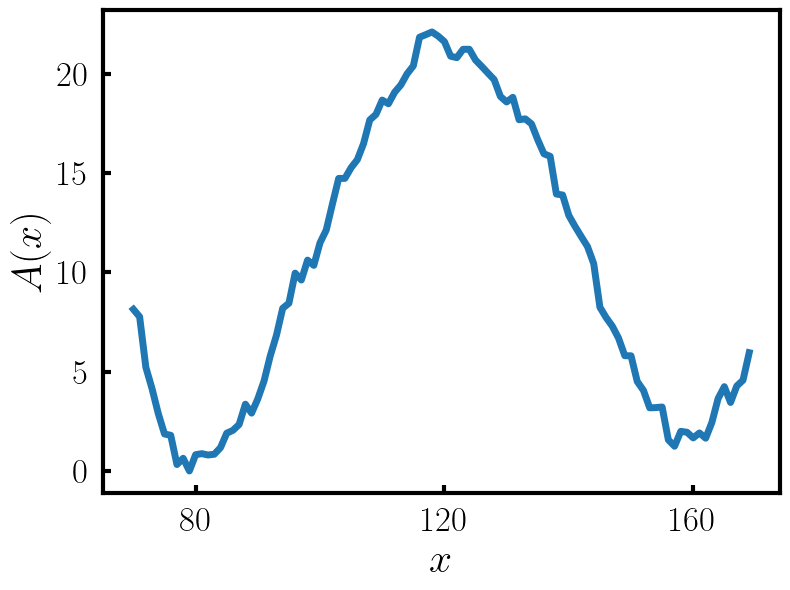

In [101]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(8,6))

#plt.plot(np.degrees(the_bias.grid[0]), the_bias.pmf[0], linewidth=5)
plt.plot(grid, pmf_mbar-pmf_mbar.min(), linewidth=5)

axs.set_xlabel(r'$x$', fontsize=30)
axs.set_ylabel(r'$A(x)$', fontsize=30)
axs.set_xticks([80,120,160])

axs.tick_params(axis='y',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.tick_params(axis='x',length=6,width=3,labelsize=25, pad=10, direction='in')
axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

### Sampling of the $(x,y)$ plane 

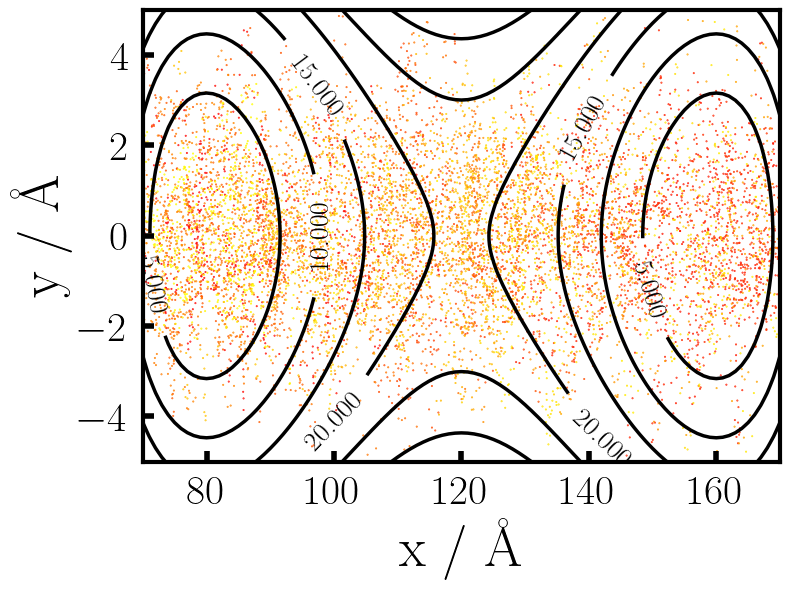

In [102]:
plt.rcParams["figure.figsize"] = [8,6]
fig, axs = plt.subplots(ncols=1)

# plot the data points
t = np.arange(len(x))
plt.scatter(x, y, s=0.2, c=t, cmap='autumn', zorder=0)

# plot the potential energy surface
CS = axs.contour(xx, yy, PES, colors='black', levels=12, linewidths=2.5, zorder=1)
plt.clabel(CS, CS.levels, inline='true', fontsize=20, fmt="%5.3f")
axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.set_ylabel('y / \AA', fontsize=40)
axs.set_xlabel('x / \AA', fontsize=40)
axs.set_xlim([70,170])
axs.set_ylim([-5,5])

axs.spines['bottom'].set_linewidth(3)
axs.spines['top'].set_linewidth(3)
axs.spines['left'].set_linewidth(3)
axs.spines['right'].set_linewidth(3)
fig.tight_layout()

#plt.savefig("sampling_double_well_pot.pdf")
plt.show()
plt.close()